# Simple MNIST convnet

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2015/06/19<br>
**Last modified:** 2020/04/21<br>
**Description:** A simple convnet that achieves ~99% test accuracy on MNIST.

## Setup

In [4]:

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


## Prepare the data

In [5]:

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Build the model

In [6]:
from tensorflow.keras import backend


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        # Question: What's the shape of the filter ?
        # tips: only conv. layers change the depths (number of channels)
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

## Train the model

In [7]:

batch_size = 128
epochs = 16

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/16
422/422 [==============================] - 30s 70ms/step - loss: 0.3647 - accuracy: 0.8910 - val_loss: 0.0792 - val_accuracy: 0.9782
Epoch 2/16
422/422 [==============================] - 30s 72ms/step - loss: 0.1087 - accuracy: 0.9663 - val_loss: 0.0571 - val_accuracy: 0.9845
Epoch 3/16
422/422 [==============================] - 30s 72ms/step - loss: 0.0830 - accuracy: 0.9745 - val_loss: 0.0458 - val_accuracy: 0.9868
Epoch 4/16
422/422 [==============================] - 29s 69ms/step - loss: 0.0675 - accuracy: 0.9790 - val_loss: 0.0390 - val_accuracy: 0.9895
Epoch 5/16
422/422 [==============================] - 31s 74ms/step - loss: 0.0599 - accuracy: 0.9817 - val_loss: 0.0353 - val_accuracy: 0.9912
Epoch 6/16
422/422 [==============================] - 29s 68ms/step - loss: 0.0528 - accuracy: 0.9835 - val_loss: 0.0372 - val_accuracy: 0.9900
Epoch 7/16
422/422 [==============================] - 30s 71ms/step - loss: 0.0489 - accuracy: 0.9844 - val_loss: 0.0330 - val_accuracy:

## Evaluate the trained model

In [8]:

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.02499333769083023
Test accuracy: 0.991599977016449


## Practice : Train a Logistice regresion model upon Mnist and report the accuracy

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 200
img_height = 200
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "max_pooling2d_1"


In [121]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [122]:
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [123]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    
    # activation.shape:(1, 12, 12, 512)
    filter_activation = activation[:, :, :, filter_index]
    return tf.reduce_mean(filter_activation)


In [124]:
def gradient_ascent_step(img, filter_index, learning_rate):
    '''
    a step of gradient_ascent_step
    '''
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [125]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[:, :, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [126]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("1.png", img)

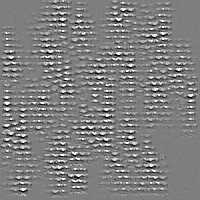

In [127]:
display(Image("1.png"))